<a href="https://colab.research.google.com/github/Karasiari/Graphs/blob/main/BigAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
%pip install "git+https://github.com/Karasiari/graphmcf.git"

  Cloning https://github.com/Karasiari/graphmcf.git to /tmp/pip-req-build-xk111mvr
  Running command git clone --filter=blob:none --quiet https://github.com/Karasiari/graphmcf.git /tmp/pip-req-build-xk111mvr
  Resolved https://github.com/Karasiari/graphmcf.git to commit cca914dbcf7a000929ea881f183981775dfb5c1a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for graphmcf: filename=graphmcf-0.1.0-py3-none-any.whl size=32953 sha256=54fbc83511a30d5999a278b12bd02ad6d72c381bf24f69892b476142bee9f2bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-z6oazt00/wheels/e2/0b/c2/f959f38e6d22c15057366b9e17b9295eb9dfc85fd11eff7962
Successfully built graphmcf


In [2]:
import pandas as pd
import numpy as np
import os # Выберите, откуда тяните папку
from google.colab import files

BITRATE_DENOMINATOR = 100

# По папке формируем словарь графов со структурой -
#                                                {'название графа (как в папке)':
#                                                       {'adj_matrix': матрица смежности взвешенного графа - веса capacity,
#                                                        'traffic_matrix': матрица корреспонденций,
#                                                        'nodes_params': {'degrees': список степеней вершин,
#                                                                         'source_demands': список суммарного входящего траффика,
#                                                                         'target_demands': список суммарного исходящего траффика,
#                                                                         'sum_demands': список усредненного траффика (source + target) / 2
#                                                                        }
#                                                       }
#                                                }

def csv_to_graph(path, demands_path, capacity_path):
  Df = pd.read_csv(path, header=None, names = ['id', 'source', 'target', 'length'])
  Traffic = pd.read_csv(demands_path, header=None, names = ['id', 'source', 'target', 'bitrate'])
  Capacity = pd.read_csv(capacity_path, header=None, names = ['name', 'value'])
  df = Df.iloc[1:].copy()
  traffic = Traffic.iloc[1:].copy()
  capacity = Capacity.iloc[1:].copy()
  df['source'] = df['source'].astype(int)
  df['target'] = df['target'].astype(int)
  #df['length'] = df['length'].astype(float)
  traffic['source'] = traffic['source'].astype(int)
  traffic['target'] = traffic['target'].astype(int)
  traffic['bitrate'] = traffic['bitrate'].astype(int) // BITRATE_DENOMINATOR
  traffic_grouped = traffic.groupby(['source', 'target']).sum().reset_index()
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='NumberOfWavelengths']['value'])

  sources = df['source'].tolist()
  targets = df['target'].tolist()
  lengths = df['length'].tolist()

  unique_vertices = set()
  for source, target in zip(sources, targets):
    unique_vertices.add(source)
    unique_vertices.add(target)
  vertex_mapping = {old: new for new, old in enumerate(unique_vertices)}
  num_vertices = len(unique_vertices)

  adj_matrix = np.zeros((num_vertices, num_vertices))
  traffic_matrix = np.zeros((num_vertices, num_vertices))

  for source, target, length in zip(sources, targets, lengths):
    new_source = vertex_mapping[source]
    new_target = vertex_mapping[target]
    #adj_matrix[new_source, new_target] = length
    #adj_matrix[new_target, new_source] = length
    adj_matrix[new_source, new_target] = capacity_value
    adj_matrix[new_target, new_source] = capacity_value

  traffic_grouped['source'] = traffic_grouped['source'].map(vertex_mapping)
  traffic_grouped['target'] = traffic_grouped['target'].map(vertex_mapping)
  for _, row in traffic_grouped.iterrows():
    traffic_matrix[row['source'], row['target']] = row['bitrate']

  nodes_params = {}

  degrees = list(np.count_nonzero(adj_matrix, axis=1).astype(np.float64))
  nodes_params['degrees'] = degrees

  source_demands = list(np.sum(traffic_matrix, axis=1))
  nodes_params['source_demands'] = source_demands

  target_demands = list(np.sum(traffic_matrix, axis=0))
  nodes_params['target_demands'] = target_demands

  sum_demands = [(i + j)/2 for (i,j) in zip(source_demands, target_demands)]
  nodes_params['sum_demands'] = sum_demands

  return (adj_matrix, traffic_matrix, nodes_params)

def get_graphs(base_path, specified_graphs, specified):
  Graphs = {}
  csv_tables = []
  for folder_name in os.listdir(base_path):
    if folder_name in specified_graphs or not specified:
      folder_path = os.path.join(base_path, folder_name)
      csv_path = os.path.join(folder_path, 'links.csv')
      csv_path_demands = os.path.join(folder_path, 'demands.csv')
      csv_path_capacity = os.path.join(folder_path, 'params.csv')
      csv_tables.append(folder_name)

      (adj_matrix, traffic_matrix, nodes_params) = csv_to_graph(csv_path, csv_path_demands, csv_path_capacity)
      Graphs[folder_name] = {'adj_matrix': adj_matrix, 'traffic_matrix': traffic_matrix, 'nodes_params': nodes_params}

  return Graphs

path_to_folder = '/content/drive/MyDrive/Кола' # Свой путь

In [14]:
small_graphs_for_mcf = []
small_names = []
small_graphs_for_test_names = ['cola_t3', 'cola_t10', 'cola_t2', 'cola_t8', '2024_north', '2024_south', '2024_southwest']
Small_Graphs_for_test = get_graphs(path_to_folder, small_graphs_for_test_names, True)
for name, graph_data in Small_Graphs_for_test.items():
    small_graphs_for_mcf.append(graph_data['adj_matrix'])
    small_names.append(name)


=== СВОДКА ПО ГРАФУ cola_t10 ===
Вершины: 83
num_edges: 4
epsilon: 0.025
Среднее initial_alpha: 0.2117
Сошедшихся запусков: 16 из 18 (88.89%)


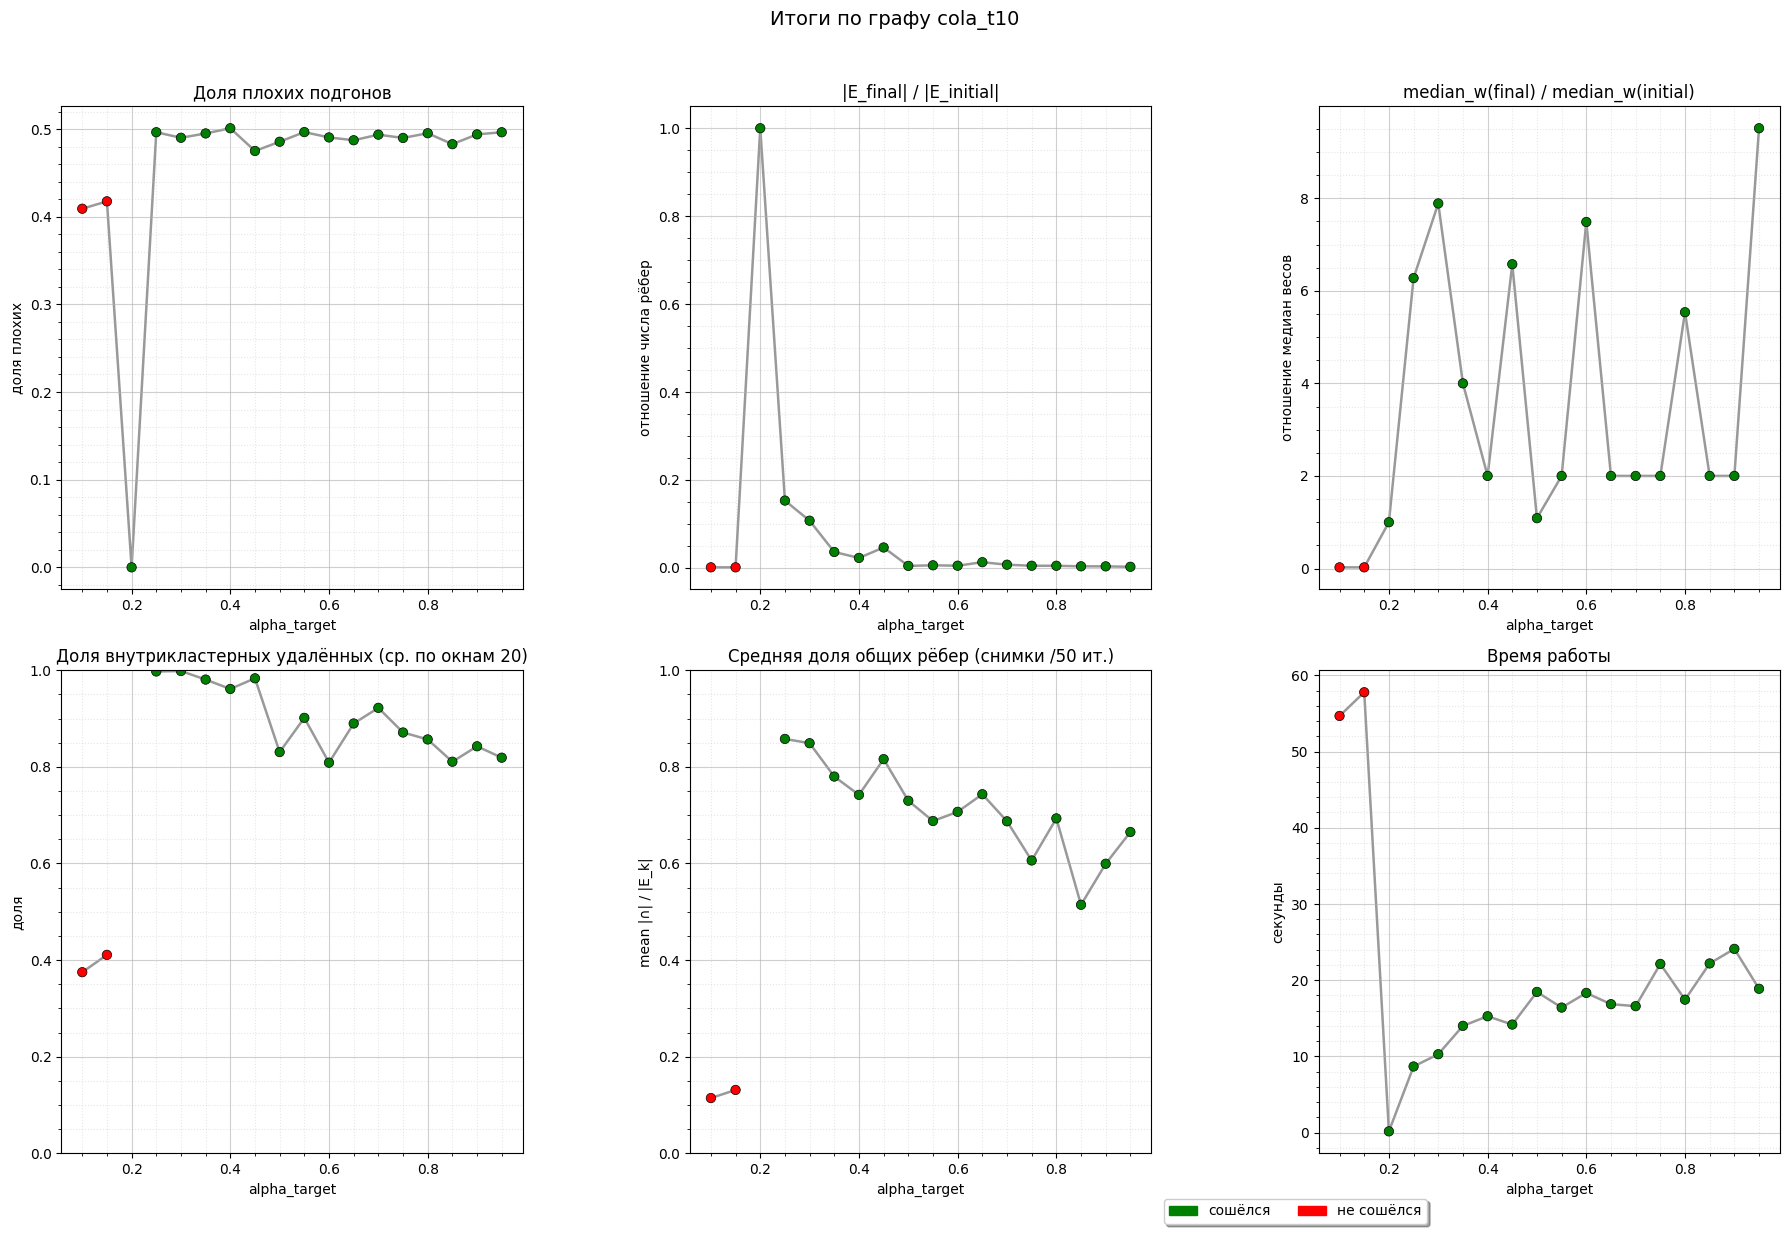


=== СВОДКА ПО ГРАФУ cola_t3 ===
Вершины: 21
num_edges: 3
epsilon: 0.025
Среднее initial_alpha: 0.2704
Сошедшихся запусков: 13 из 18 (72.22%)


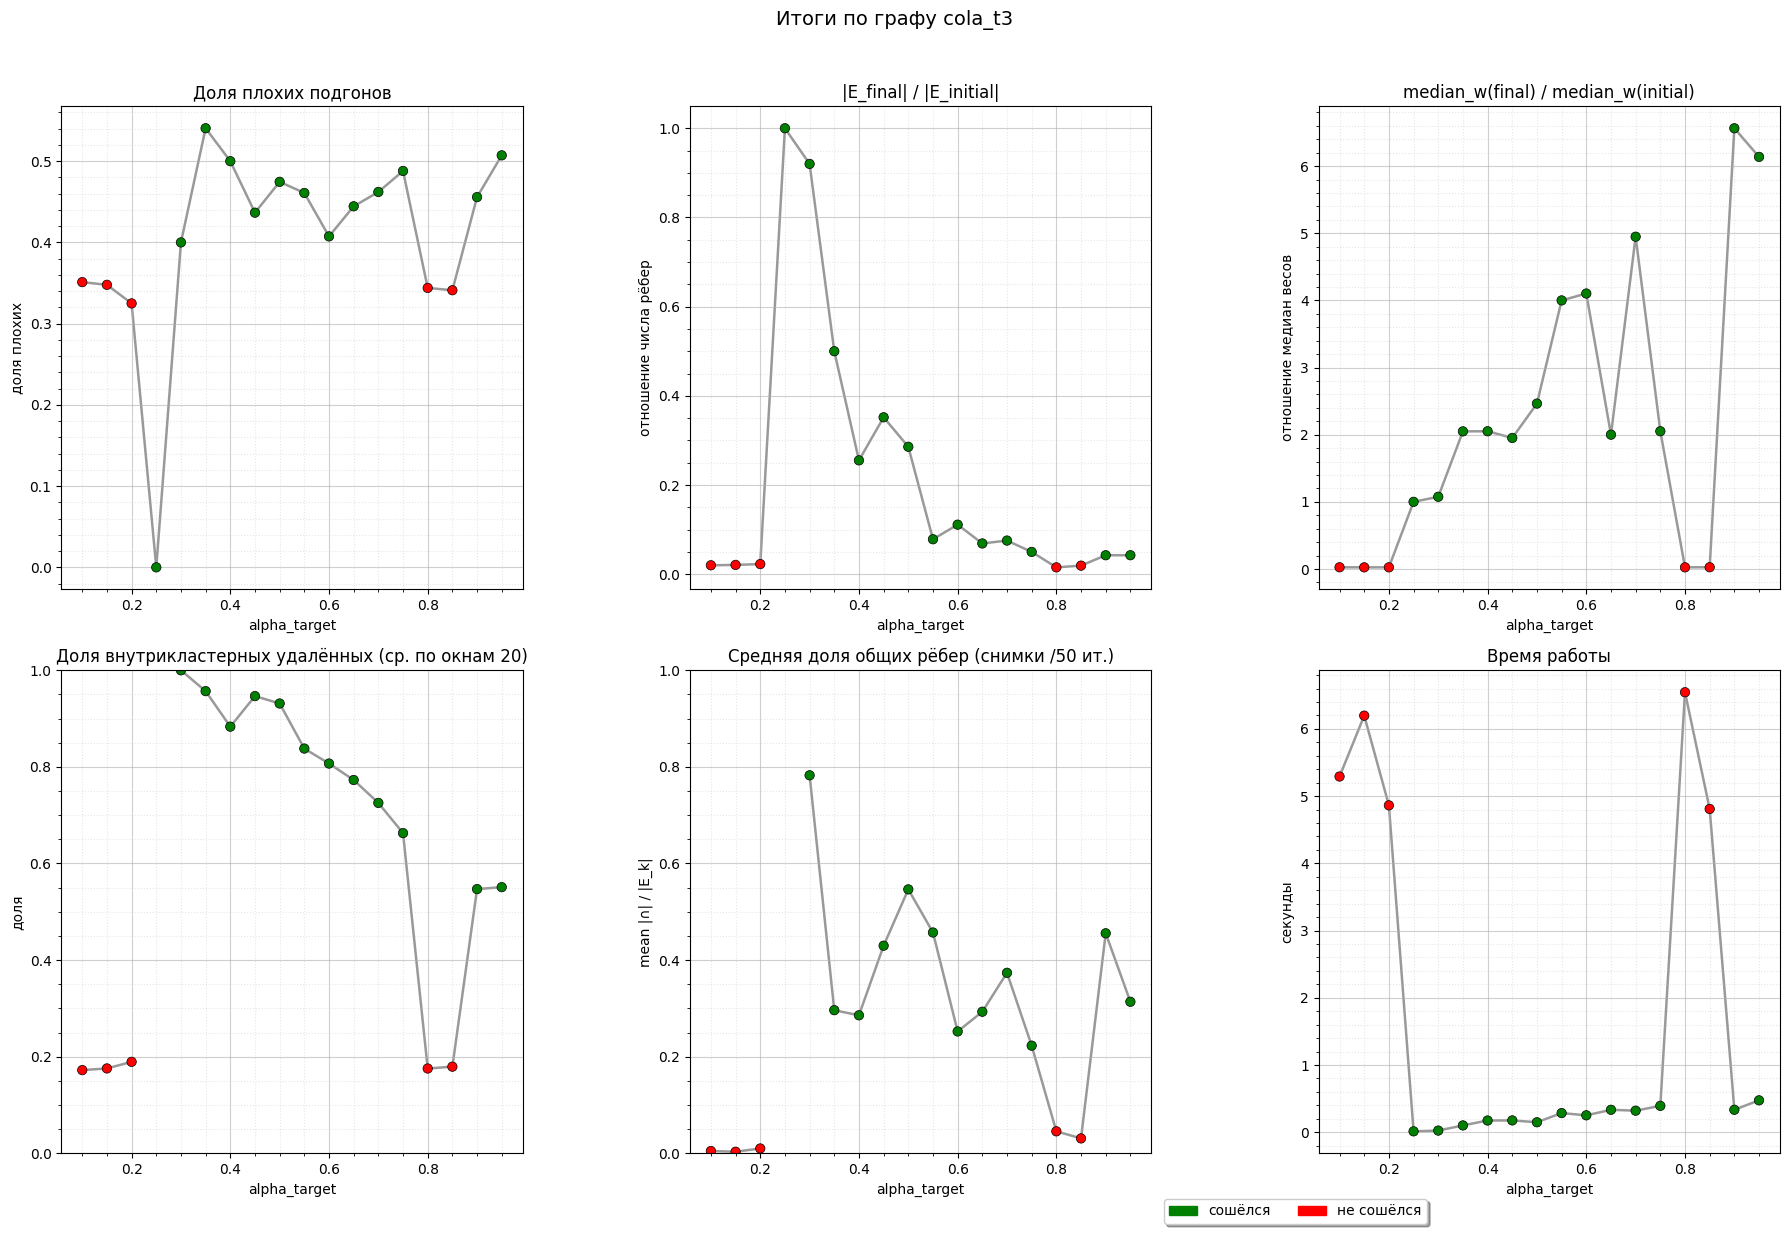


=== СВОДКА ПО ГРАФУ cola_t8 ===
Вершины: 54
num_edges: 3
epsilon: 0.025
Среднее initial_alpha: 0.3303
Сошедшихся запусков: 15 из 18 (83.33%)


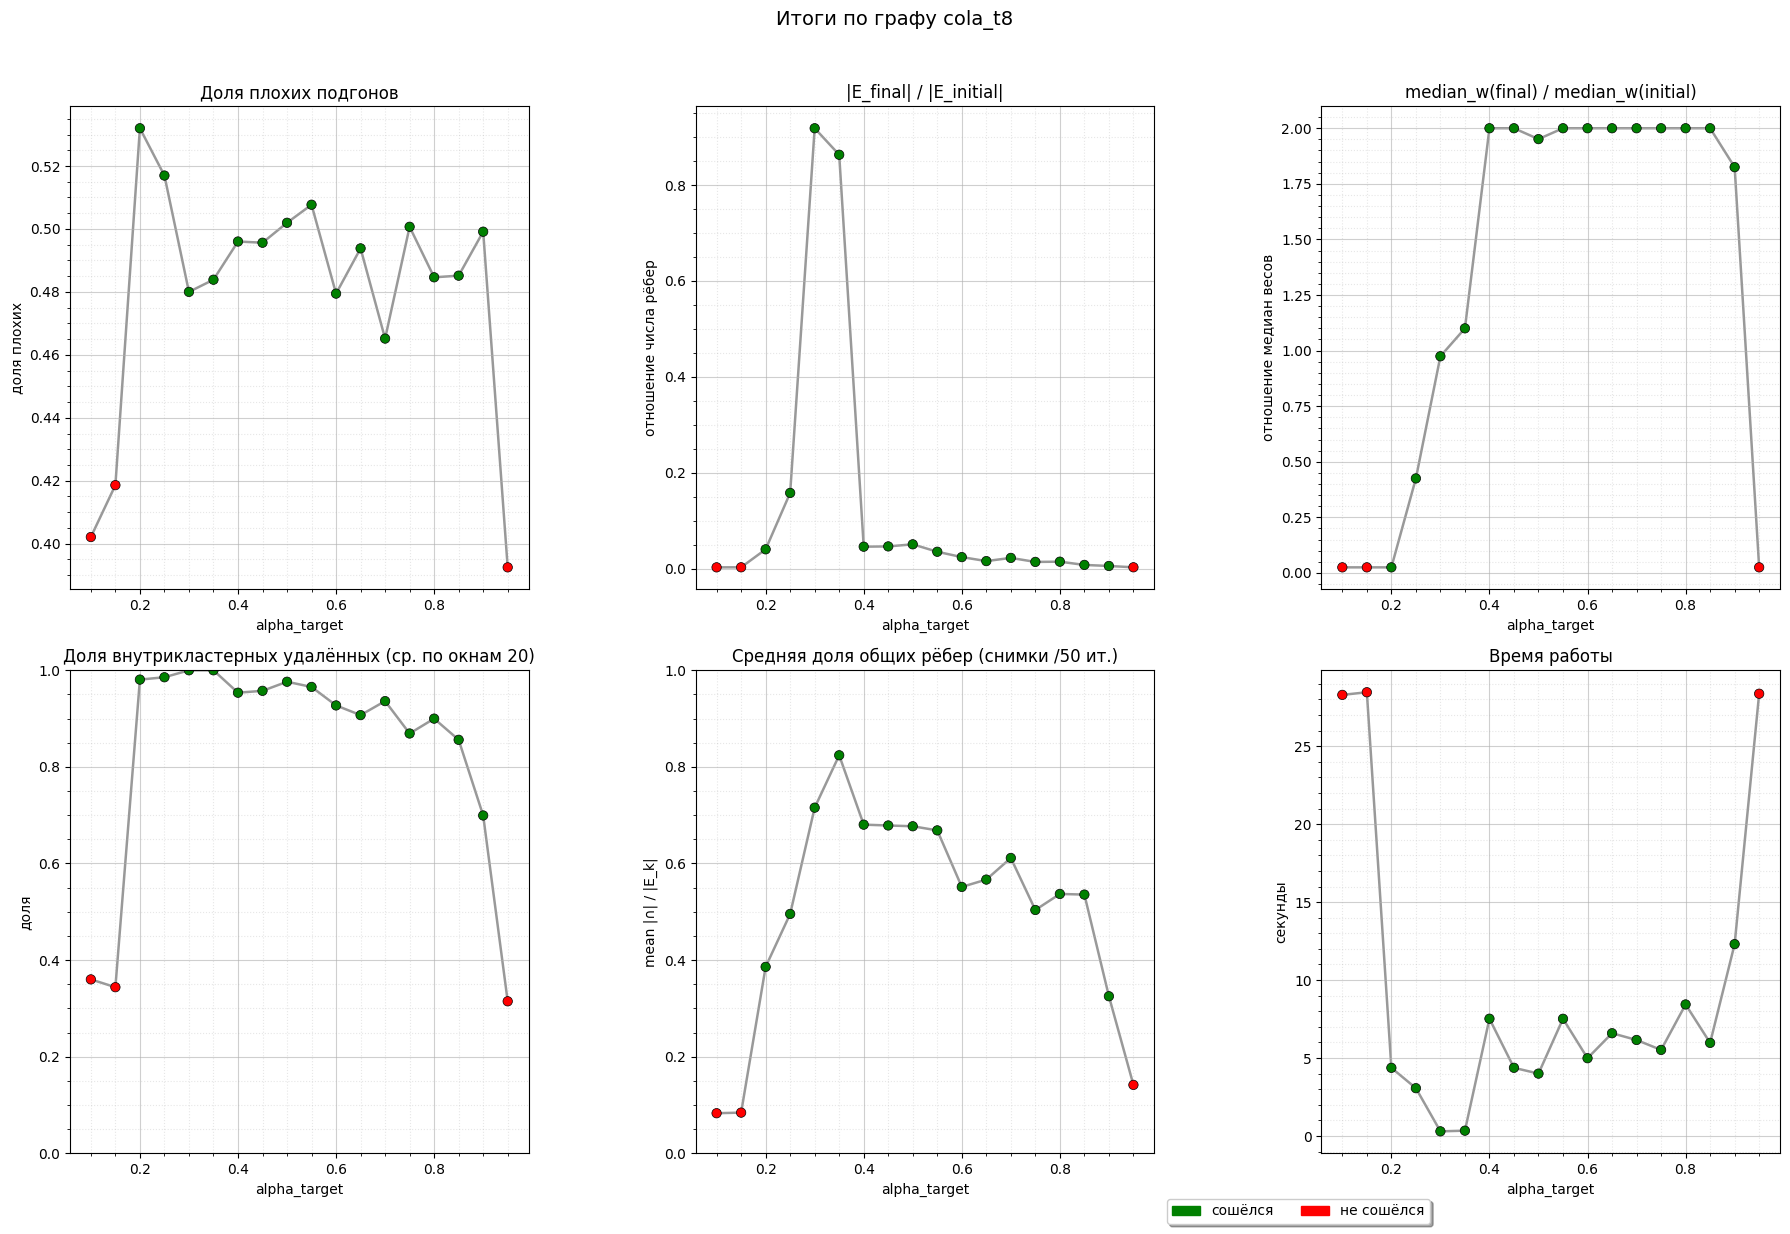


=== СВОДКА ПО ГРАФУ cola_t2 ===
Вершины: 32
num_edges: 3
epsilon: 0.025
Среднее initial_alpha: 0.1912
Сошедшихся запусков: 16 из 18 (88.89%)


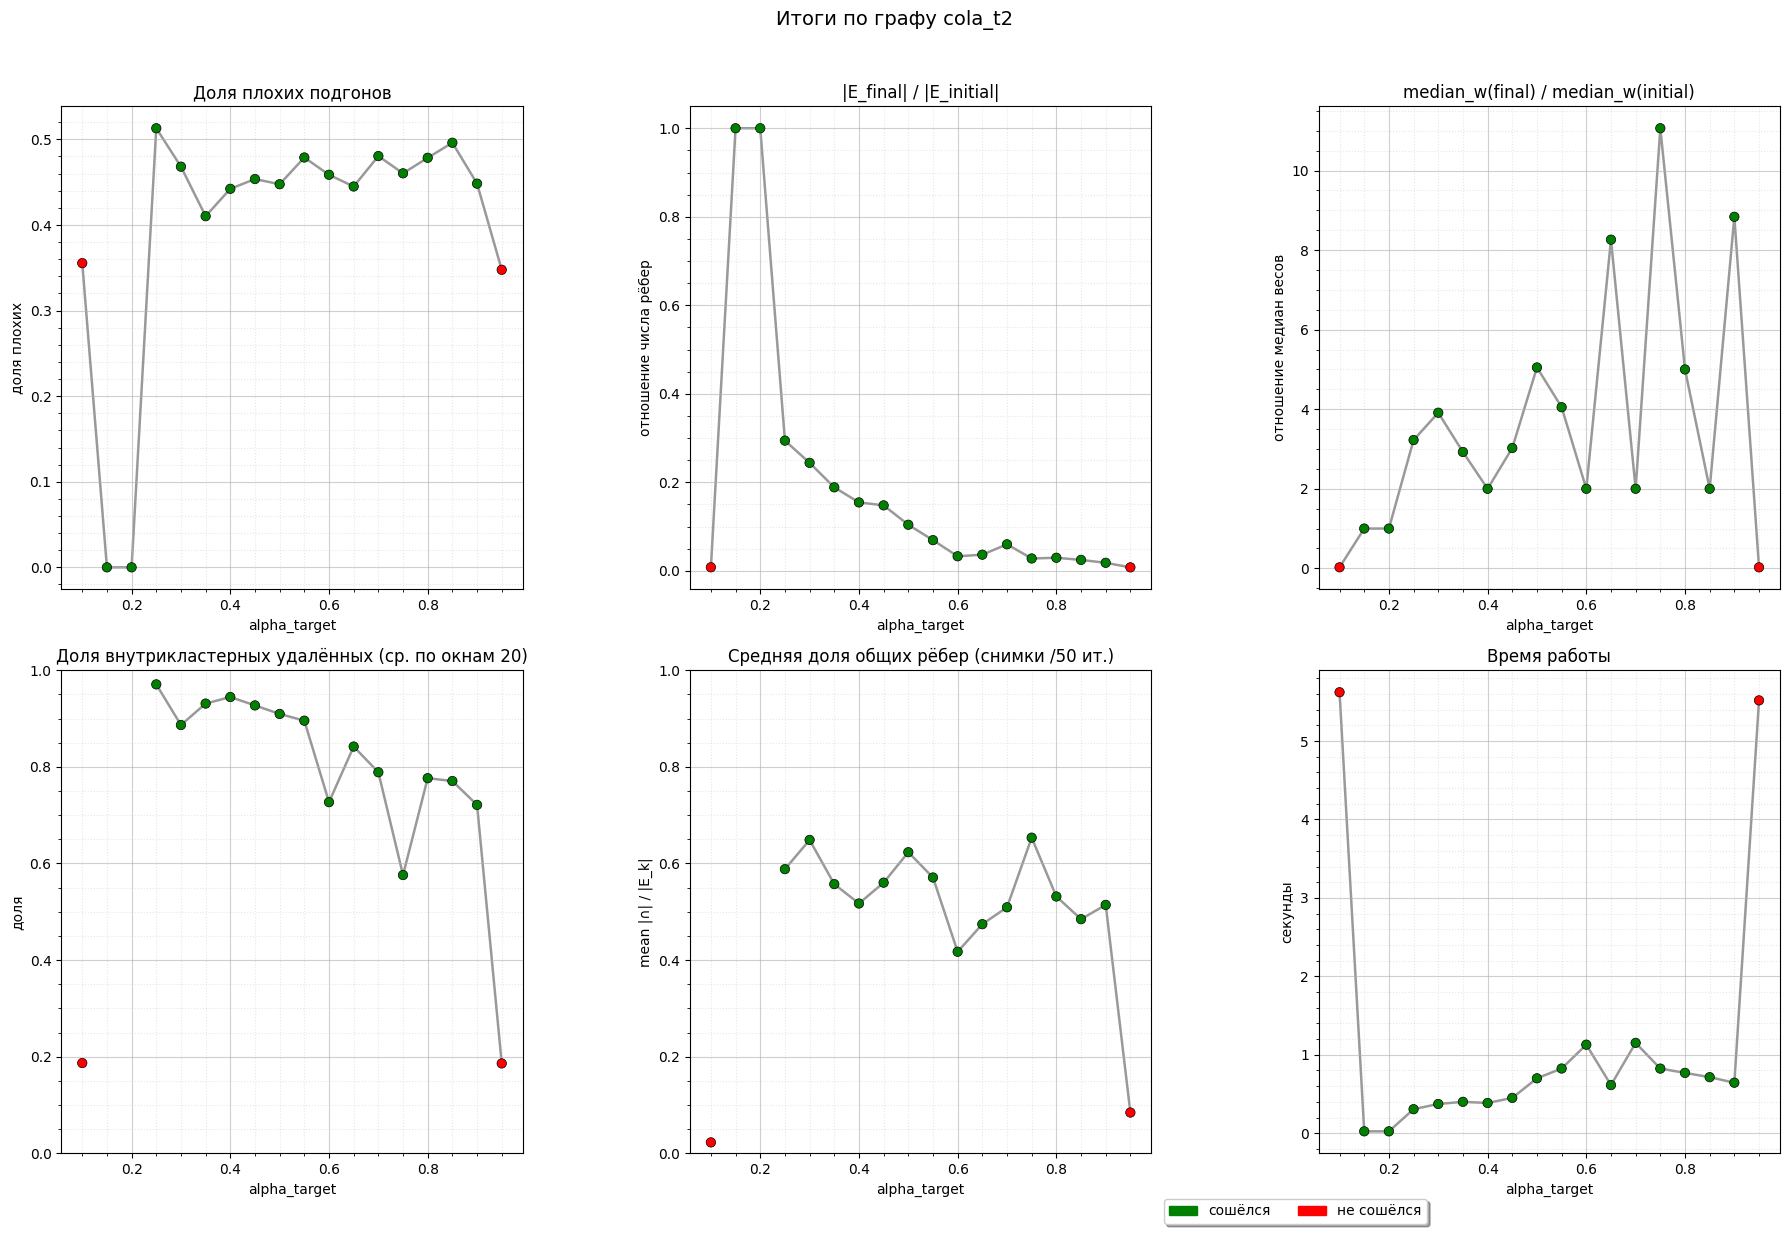


=== СВОДКА ПО ГРАФУ 2024_southwest ===
Вершины: 50
num_edges: 3
epsilon: 0.025
Среднее initial_alpha: 0.2581
Сошедшихся запусков: 16 из 18 (88.89%)


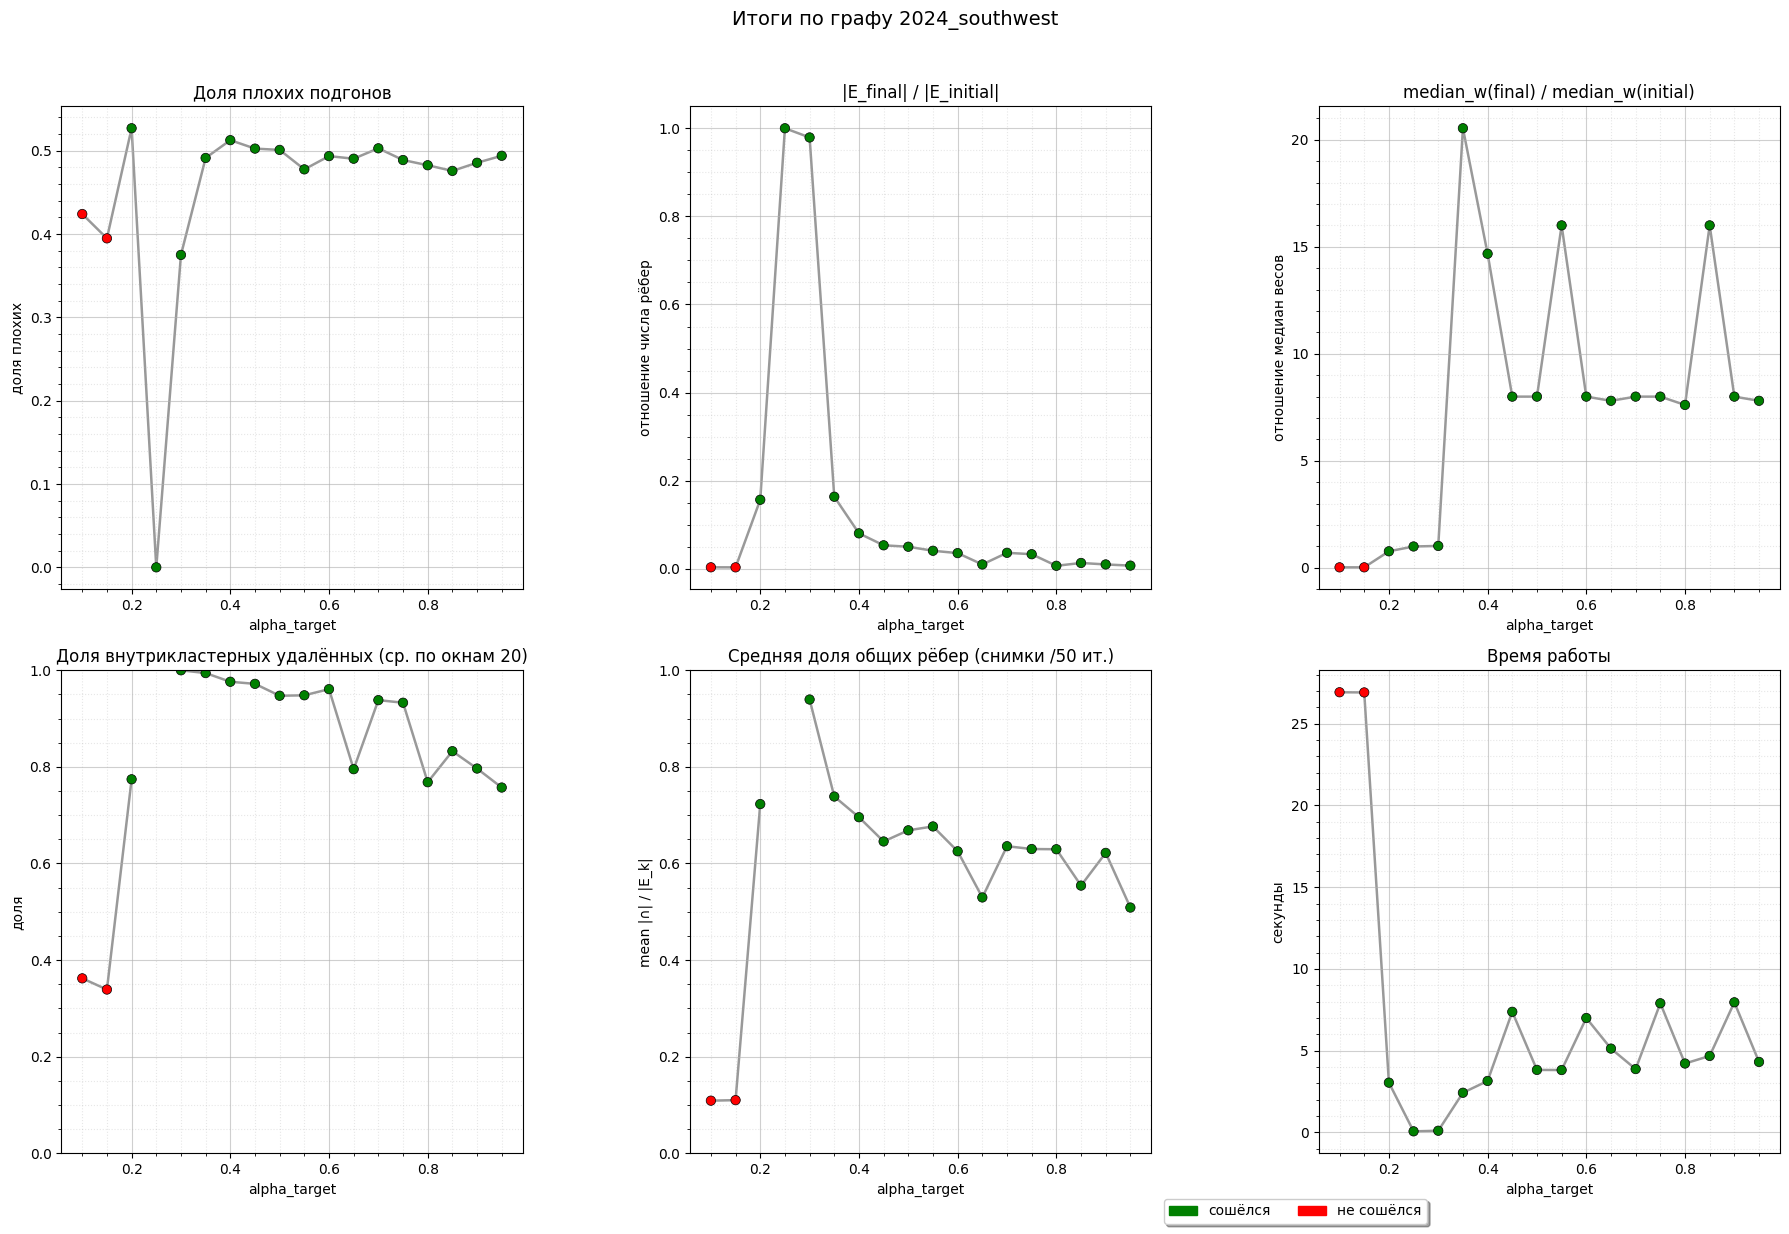


=== СВОДКА ПО ГРАФУ 2024_south ===
Вершины: 73
num_edges: 3
epsilon: 0.025
Среднее initial_alpha: 0.2337
Сошедшихся запусков: 16 из 18 (88.89%)


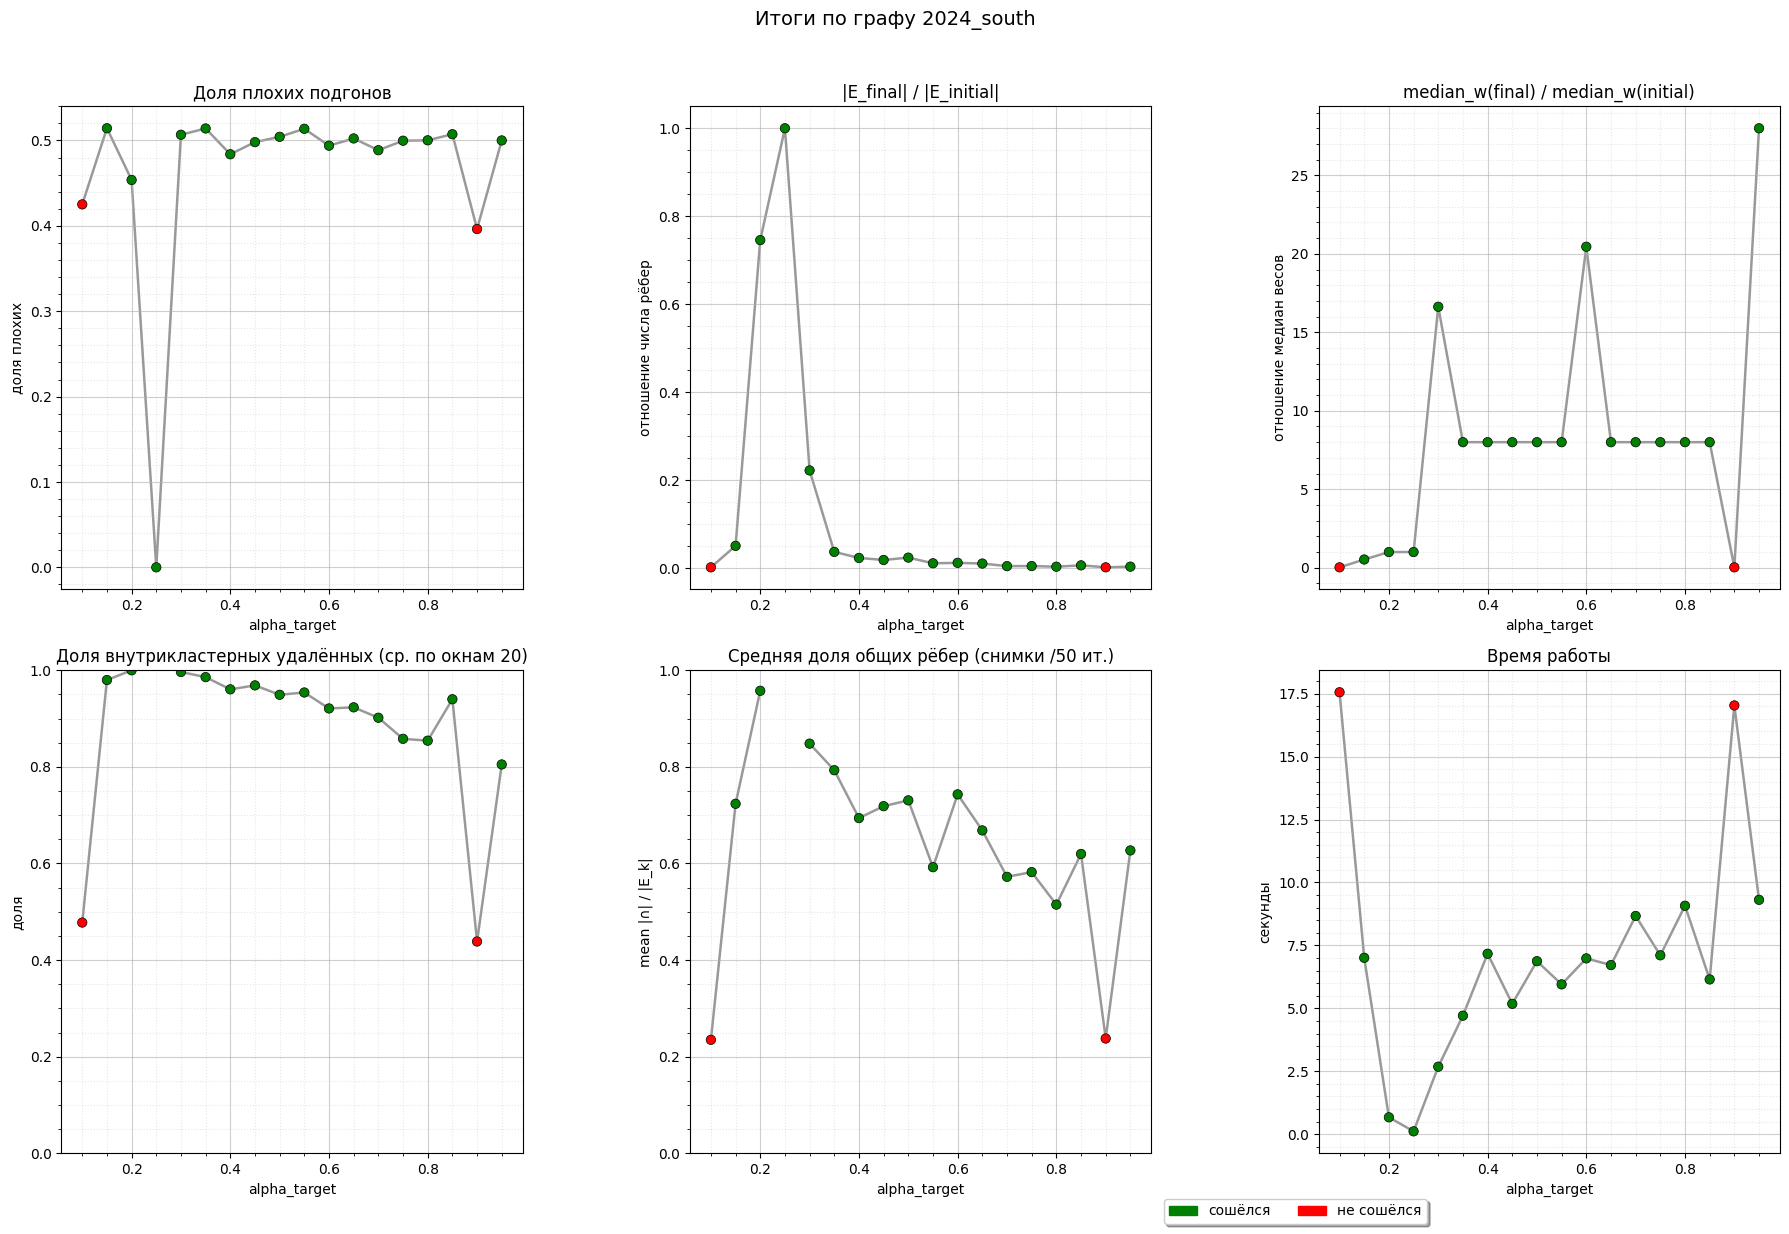


=== СВОДКА ПО ГРАФУ 2024_north ===
Вершины: 73
num_edges: 3
epsilon: 0.025
Среднее initial_alpha: 0.2265
Сошедшихся запусков: 16 из 18 (88.89%)


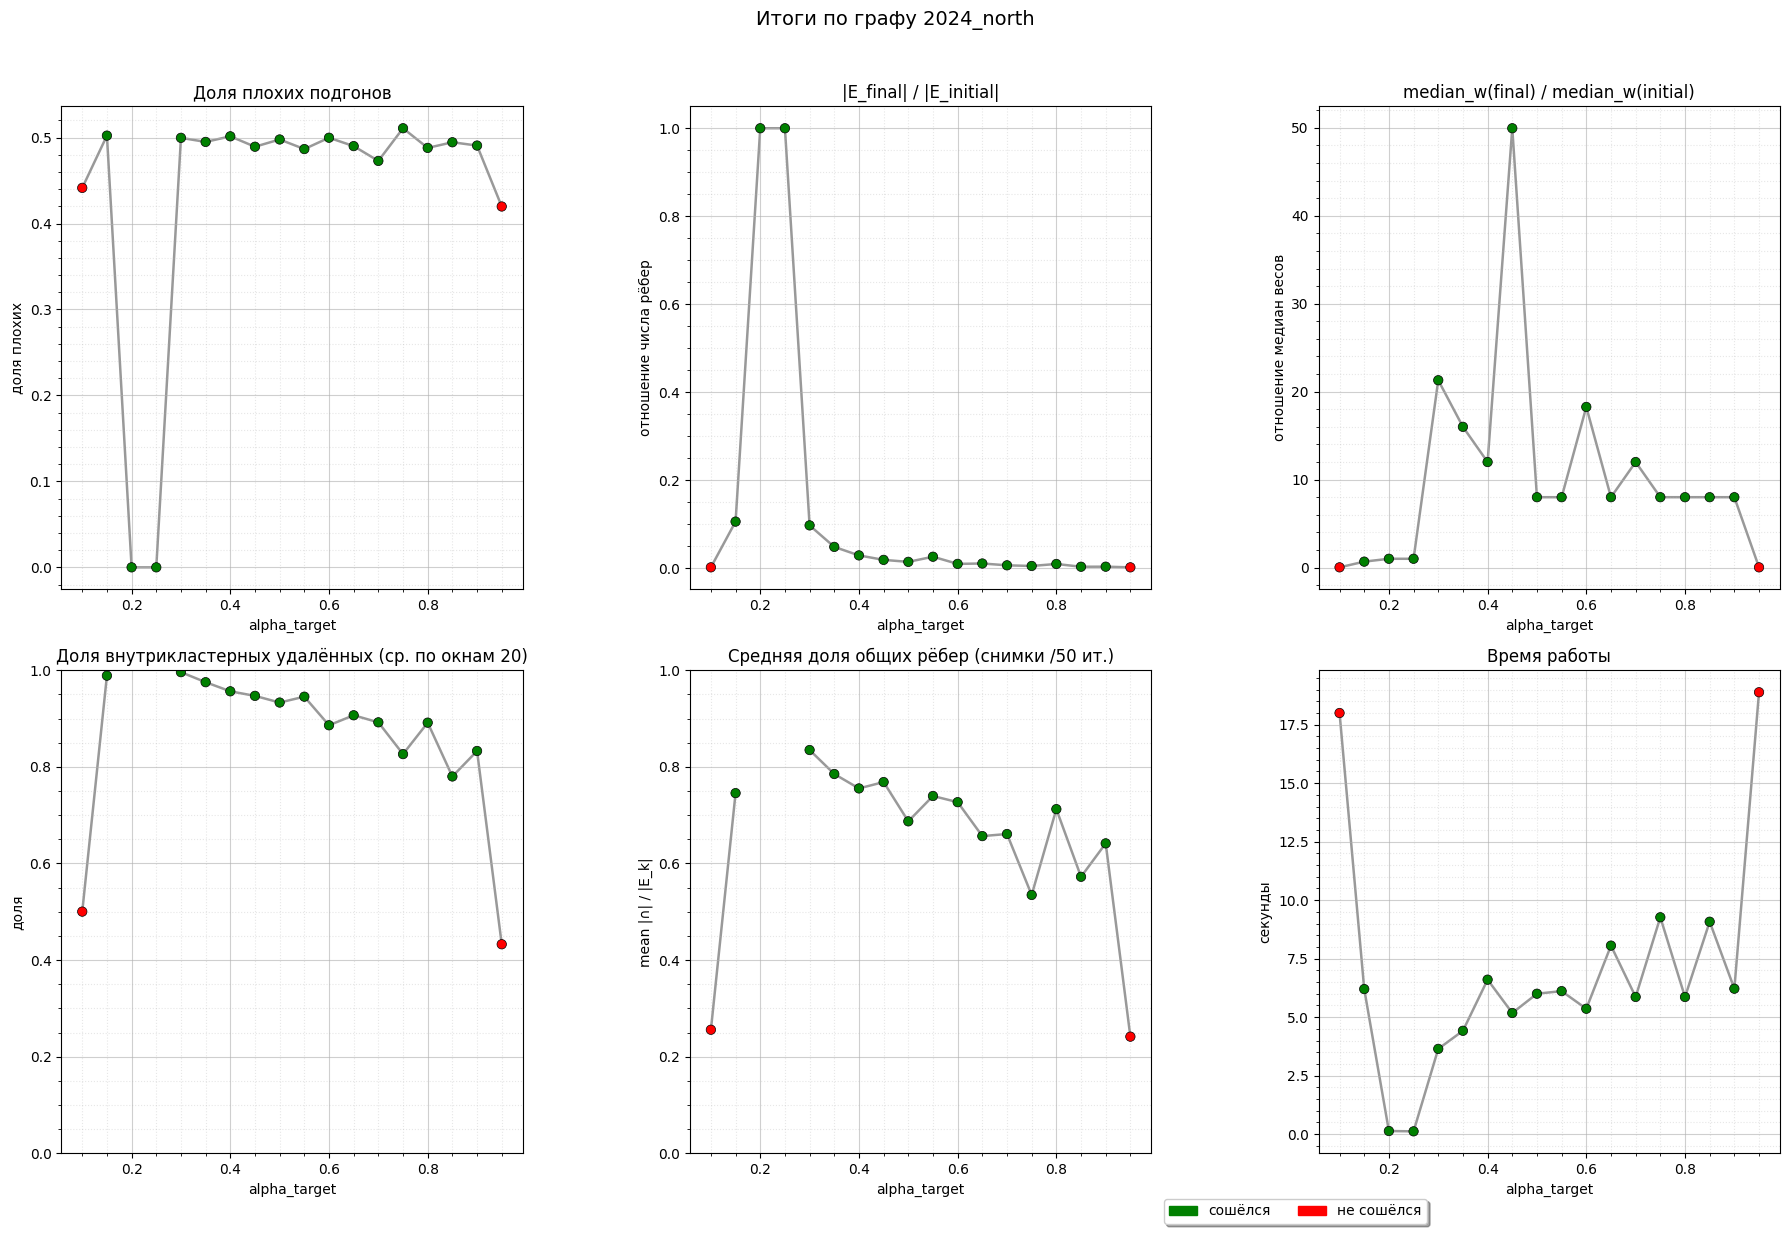

In [16]:
import numpy as np
from graphmcf.batch.runner_multi_edges import GraphMCFBatchMultiEdges

batch = GraphMCFBatchMultiEdges(small_graphs_for_mcf, graph_names=small_names)

alphas = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
out = batch.run_mcf_over_per_graph(alpha_values=alphas,
                                   epsilon=0.025,
                                   p_ER = 0.25, distribution="normal", median_weight_for_initial=40, var_for_initial=20,
                                   demands_median_denominator=2, demands_var_denominator=4,
                                   num_edges=None, p_for_delete_edge=1.0, p_for_upsert_edge=1.0,)

In [15]:
graphs_for_test_names = ['cola_t3', 'cola_t10', 'cola_t2', 'cola_t8', 'cola_t7']
Graphs_for_test = get_graphs(path_to_folder, graphs_for_test_names, True)

====================================   Анализ работы алгоритма для cola_t10  ====================================
=== АНАЛИЗ (single run) ===
num_edges=4, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 18.20 c
Итераций: 2626 (доля от максимума 8300 = 31.64%)
alpha_target=0.5, epsilon=0.05
initial_alpha=0.2187, final_alpha=0.4766, converged=True
Плохие шаги всего: 1267 (доля 0.48)
  — adversarial-плохих: 1267 (доля 0.48)
  — friendly-плохих:   0 (доля 0.00)


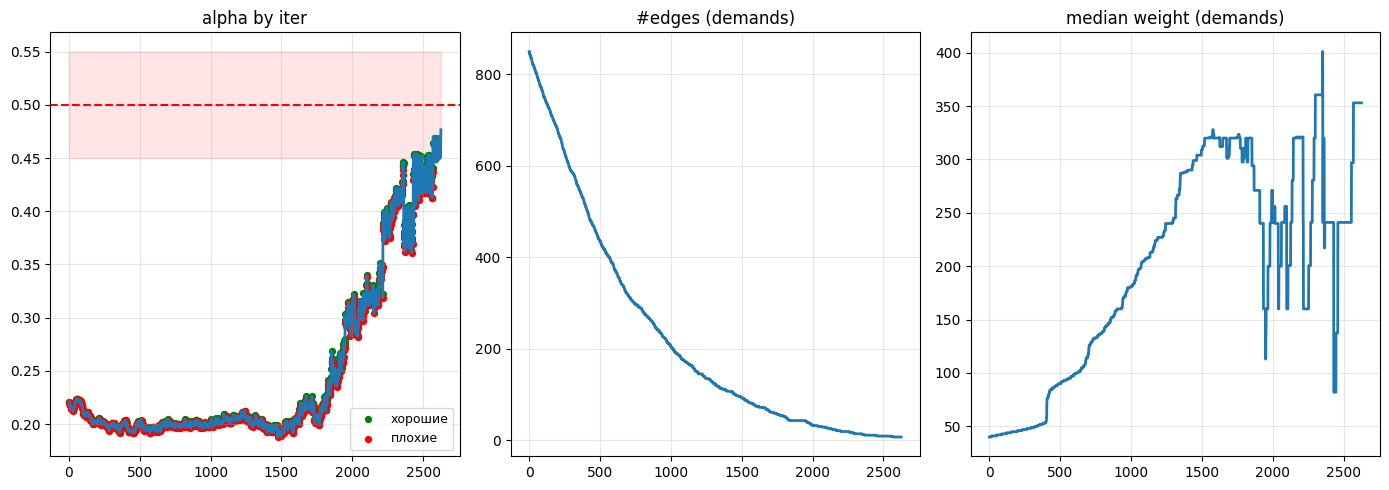

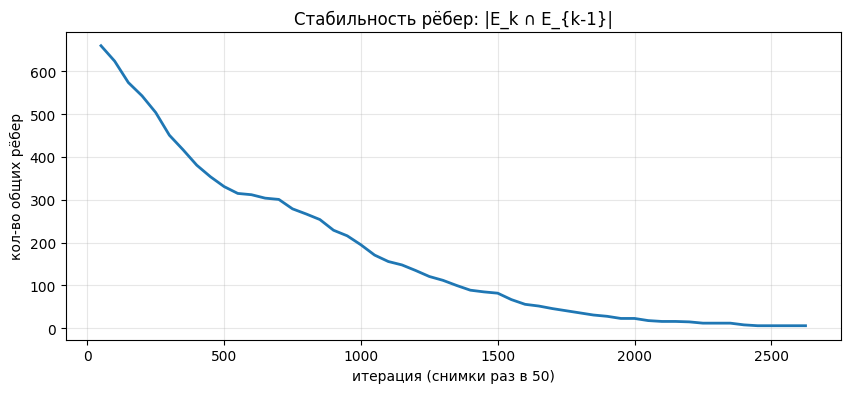

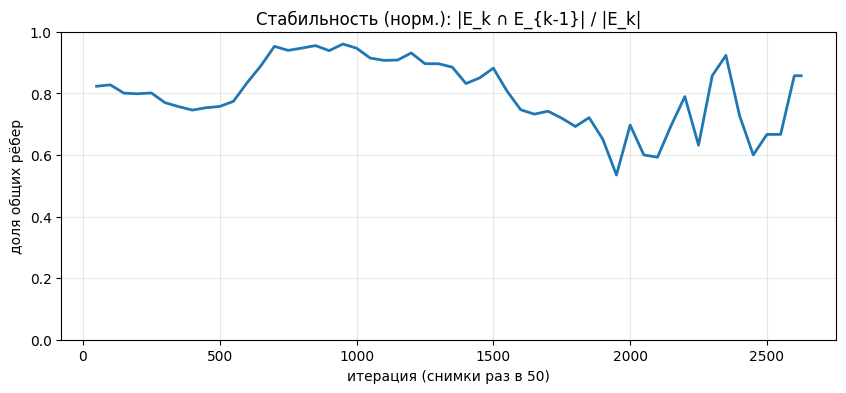

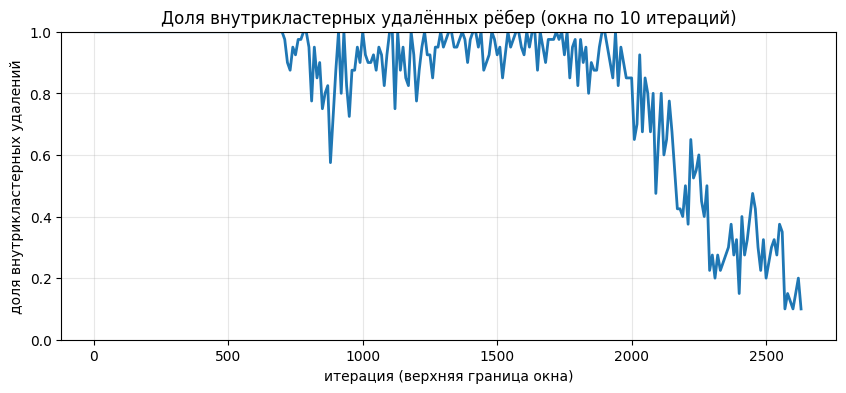

 метрика  initial  final
   edges      850      7
median_w       40    353
  mean_w       40    343
   sum_w    33849   2398


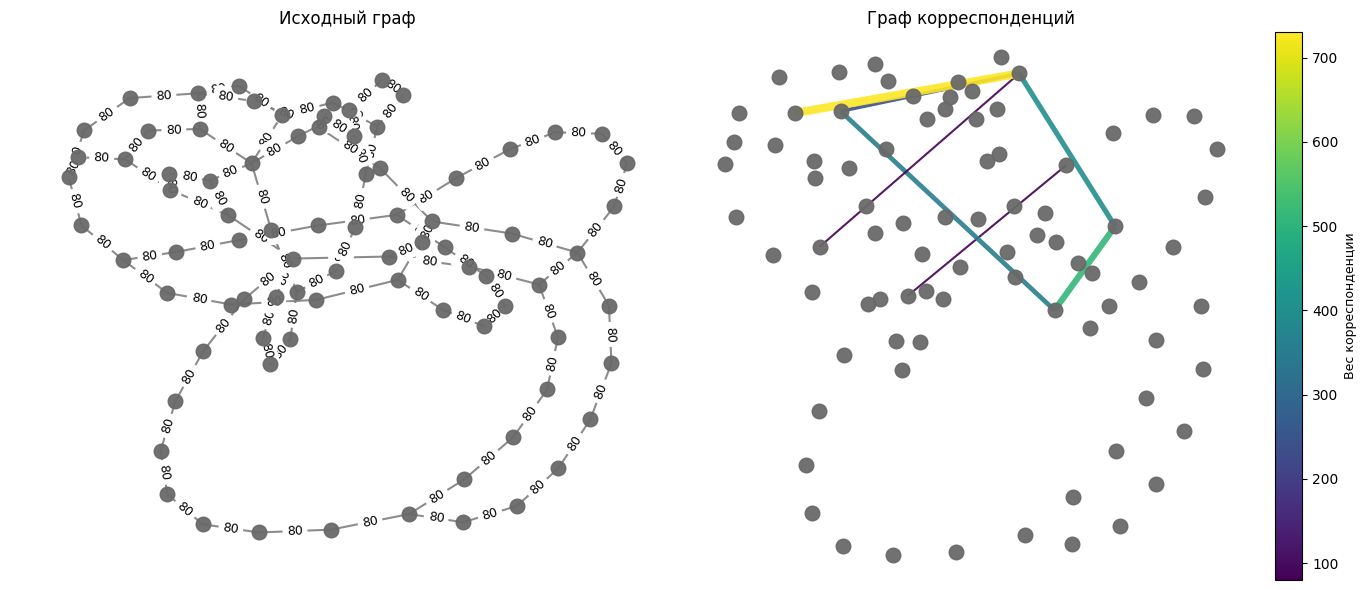

=================================== Конец анализа работы алгоритма для cola_t10 ===================================
====================================   Анализ работы алгоритма для cola_t3  ====================================
=== АНАЛИЗ (single run) ===
num_edges=3, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 0.48 c
Итераций: 91 (доля от максимума 2100 = 4.33%)
alpha_target=0.5, epsilon=0.05
initial_alpha=0.3062, final_alpha=0.4935, converged=True
Плохие шаги всего: 37 (доля 0.41)
  — adversarial-плохих: 37 (доля 0.41)
  — friendly-плохих:   0 (доля 0.00)


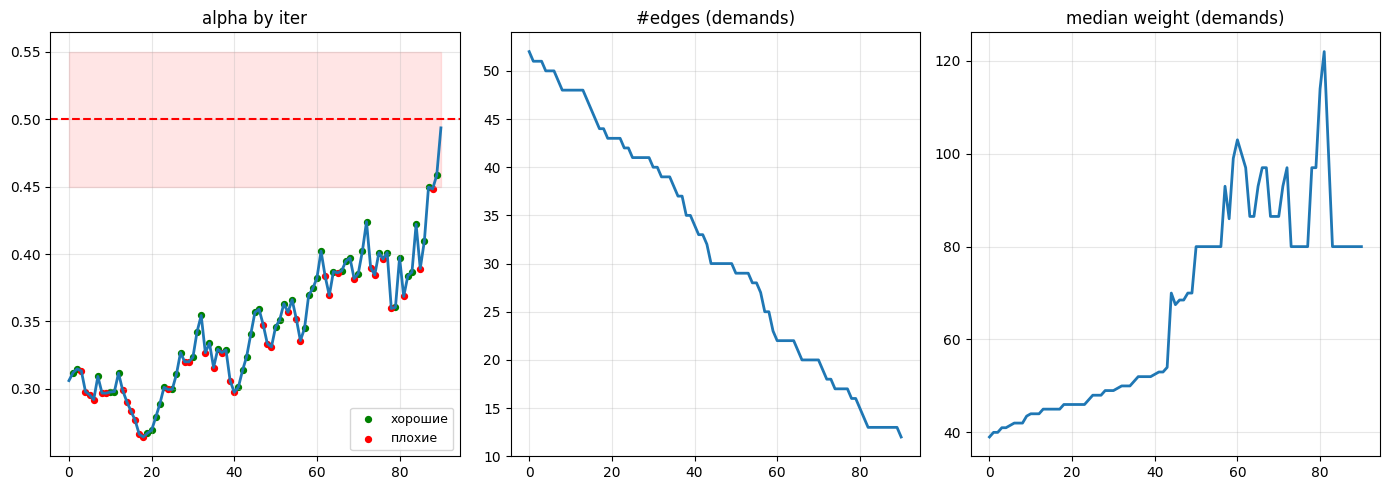

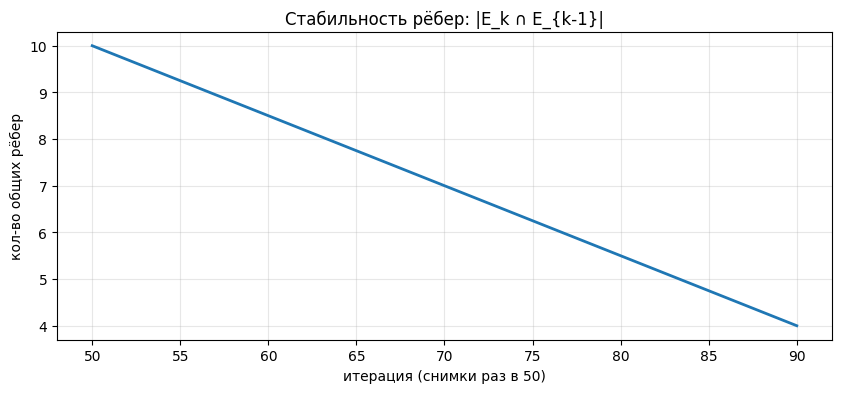

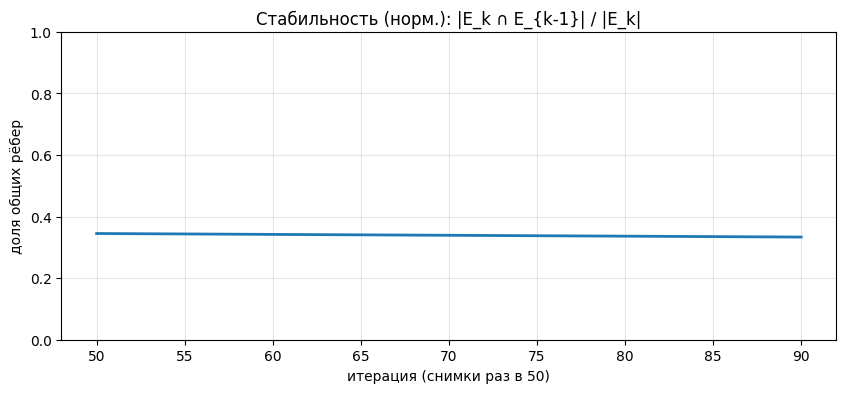

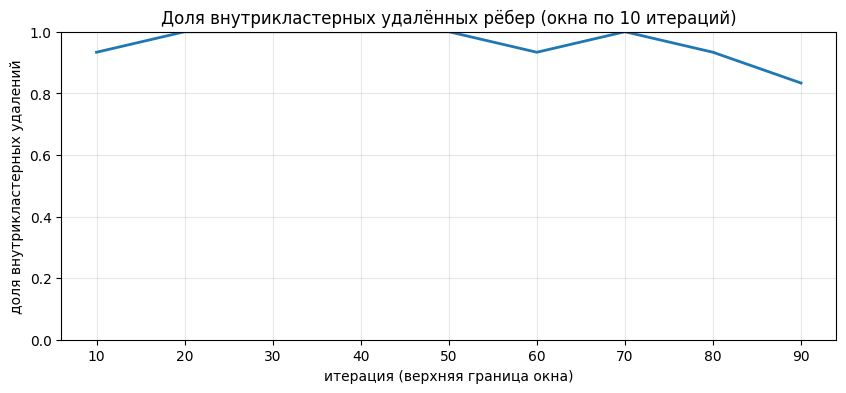

 метрика  initial  final
   edges       52     12
median_w       39     80
  mean_w       40    116
   sum_w     2066   1394


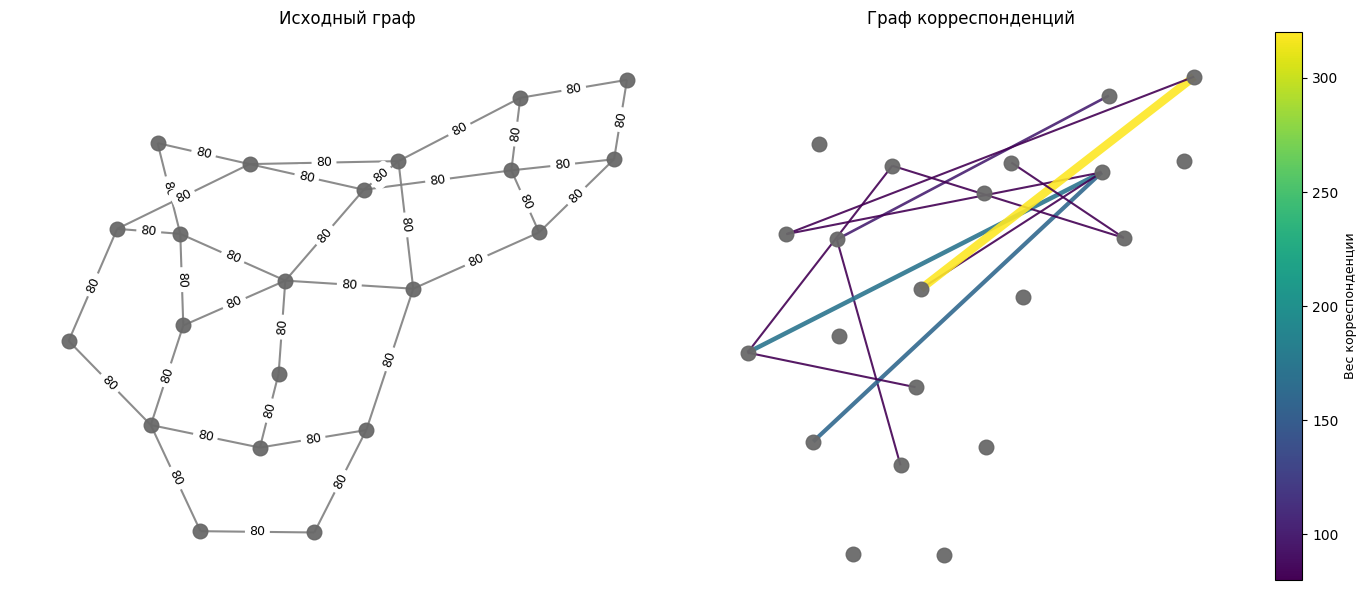

=================================== Конец анализа работы алгоритма для cola_t3 ===================================
====================================   Анализ работы алгоритма для cola_t7  ====================================
=== АНАЛИЗ (single run) ===
num_edges=4, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 159.91 c
Итераций: 12051 (доля от максимума 16200 = 74.39%)
alpha_target=0.5, epsilon=0.05
initial_alpha=0.1794, final_alpha=0.4895, converged=True
Плохие шаги всего: 5944 (доля 0.49)
  — adversarial-плохих: 5944 (доля 0.49)
  — friendly-плохих:   0 (доля 0.00)


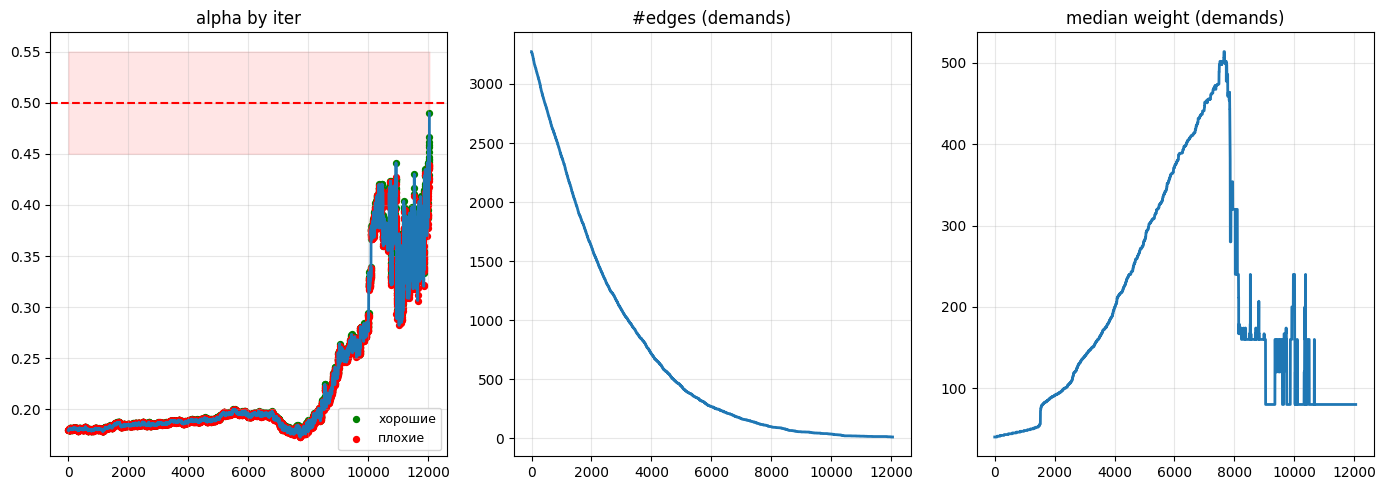

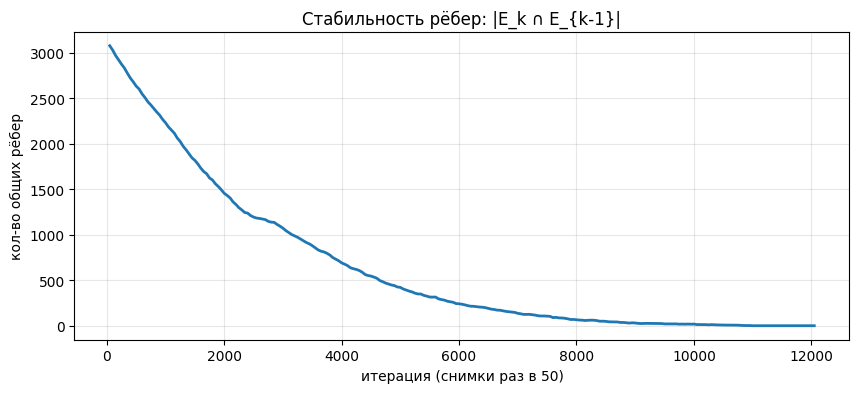

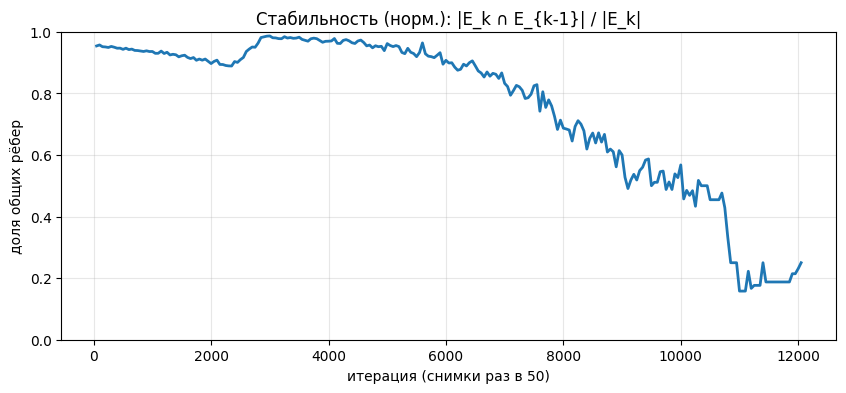

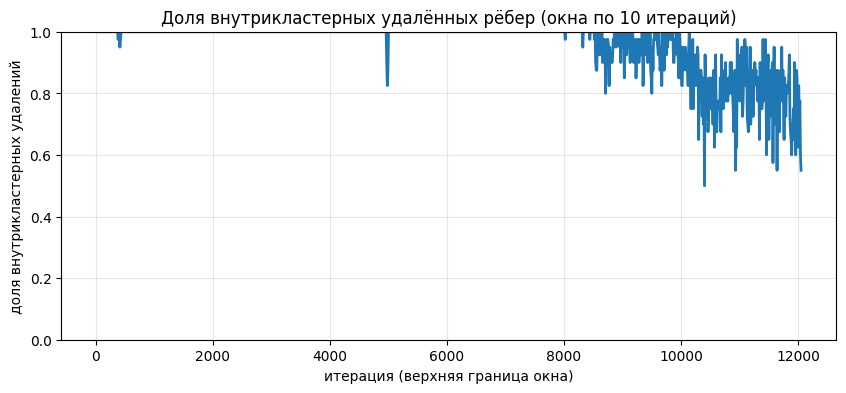

 метрика  initial  final
   edges     3274     12
median_w       40     80
  mean_w       40    148
   sum_w   130616   1774


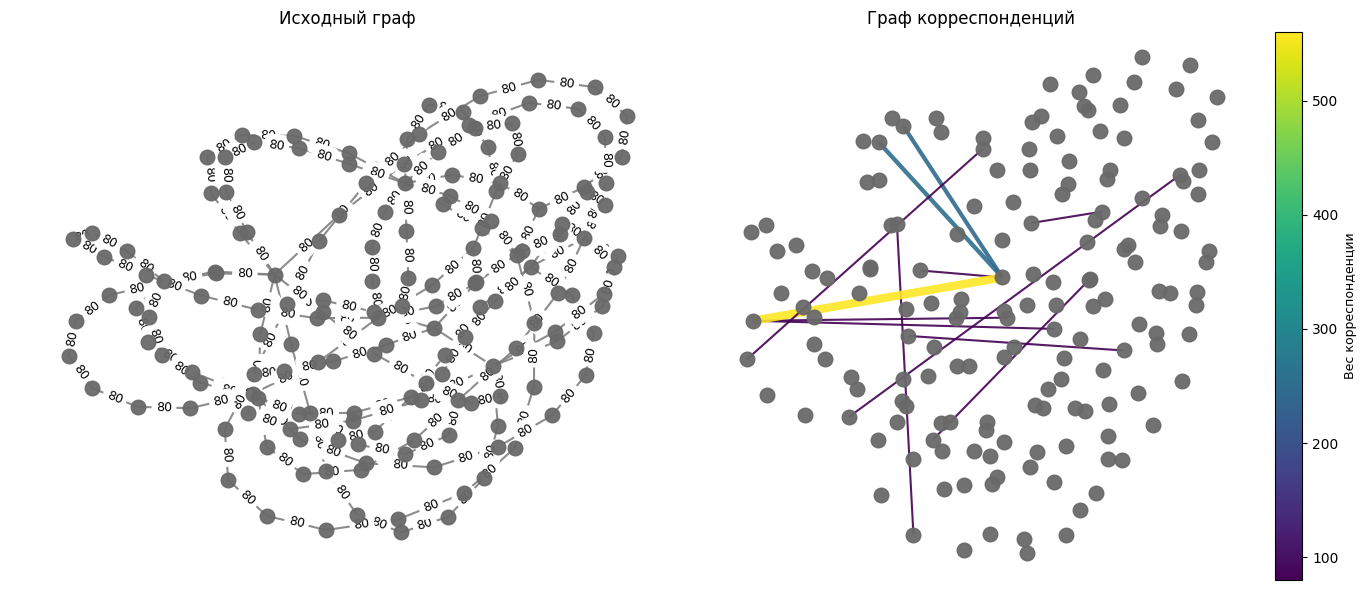

=================================== Конец анализа работы алгоритма для cola_t7 ===================================
====================================   Анализ работы алгоритма для cola_t8  ====================================
=== АНАЛИЗ (single run) ===
num_edges=3, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 5.01 c
Итераций: 1210 (доля от максимума 5400 = 22.41%)
alpha_target=0.5, epsilon=0.05
initial_alpha=0.3192, final_alpha=0.4847, converged=True
Плохие шаги всего: 592 (доля 0.49)
  — adversarial-плохих: 592 (доля 0.49)
  — friendly-плохих:   0 (доля 0.00)


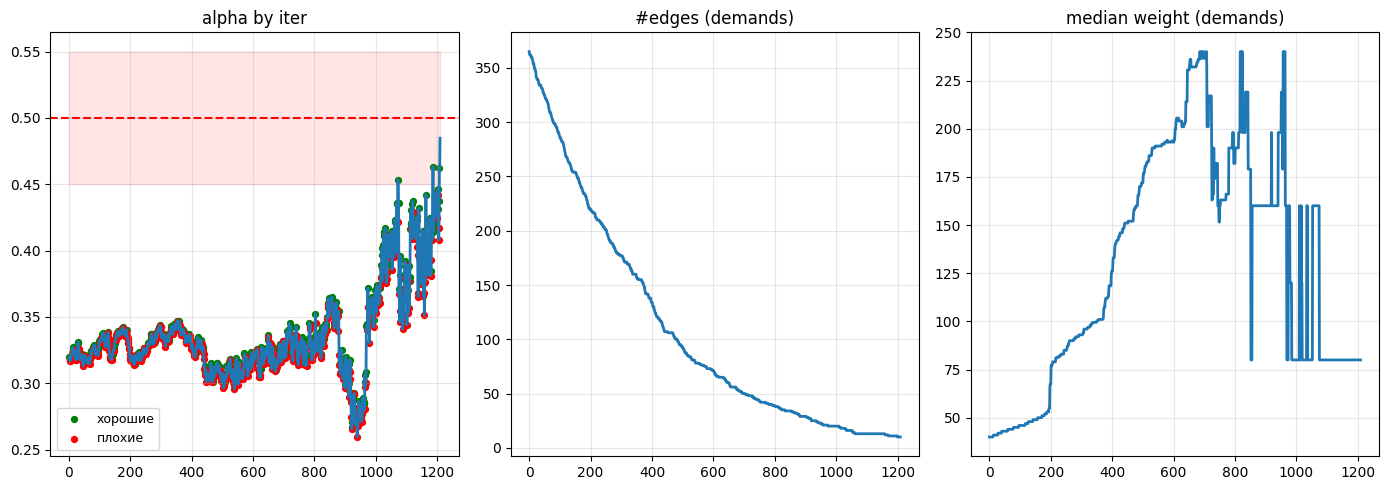

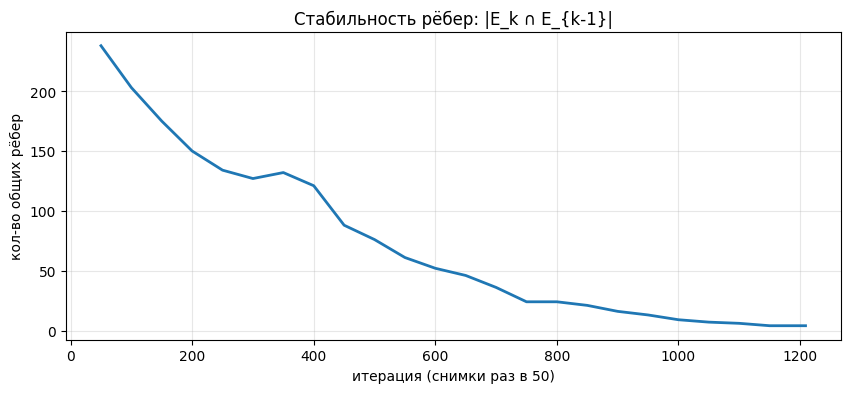

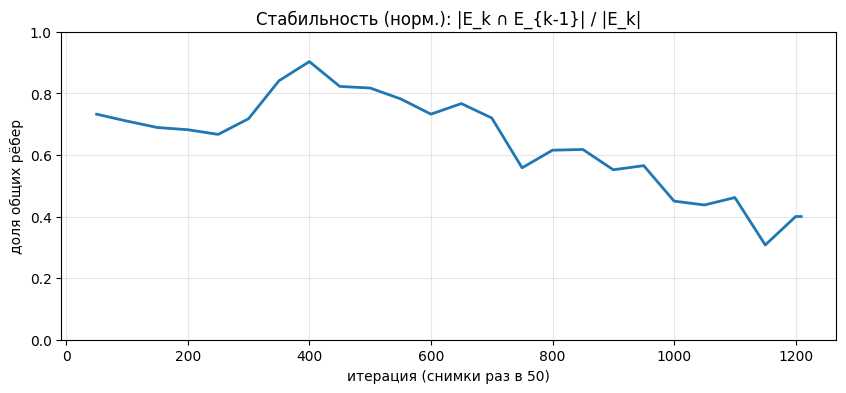

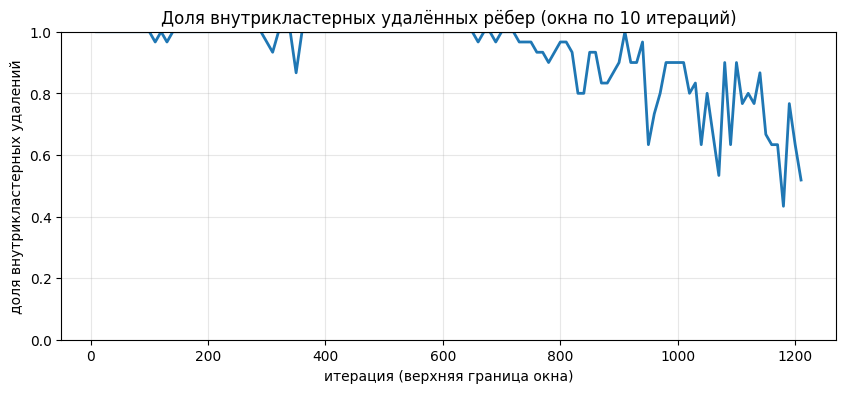

 метрика  initial  final
   edges      365     10
median_w       40     80
  mean_w       40    161
   sum_w    14616   1613


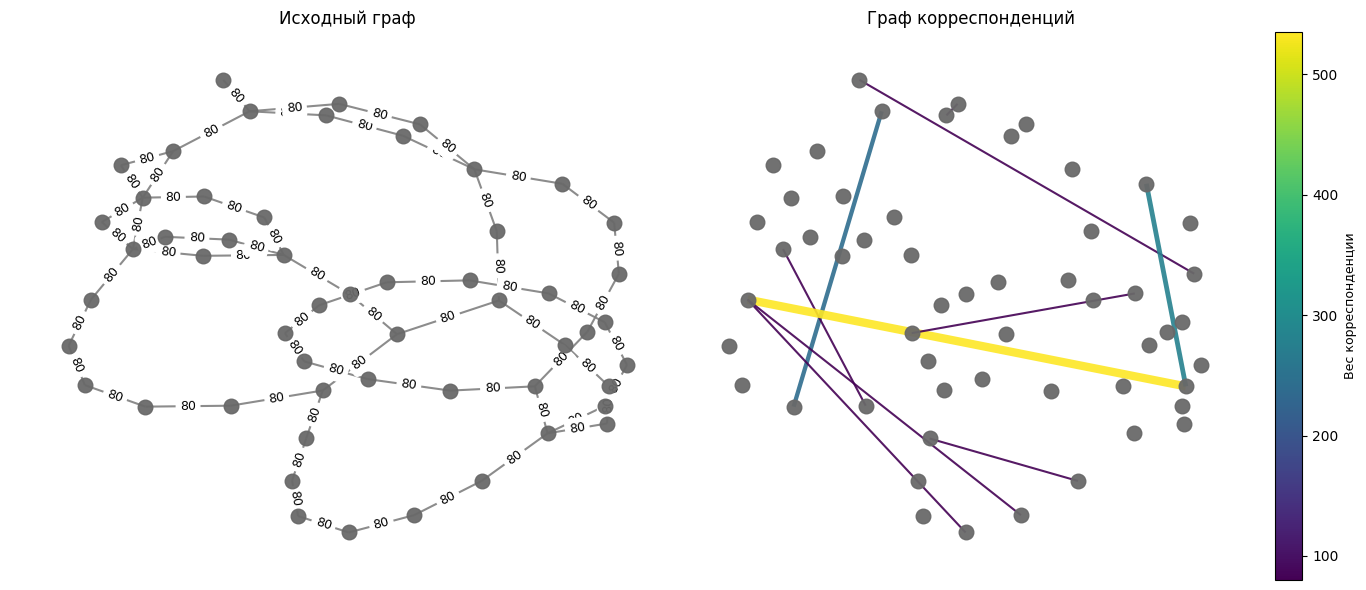

=================================== Конец анализа работы алгоритма для cola_t8 ===================================
====================================   Анализ работы алгоритма для cola_t2  ====================================
=== АНАЛИЗ (single run) ===
num_edges=3, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 0.63 c
Итераций: 265 (доля от максимума 3200 = 8.28%)
alpha_target=0.5, epsilon=0.05
initial_alpha=0.1859, final_alpha=0.4765, converged=True
Плохие шаги всего: 121 (доля 0.46)
  — adversarial-плохих: 121 (доля 0.46)
  — friendly-плохих:   0 (доля 0.00)


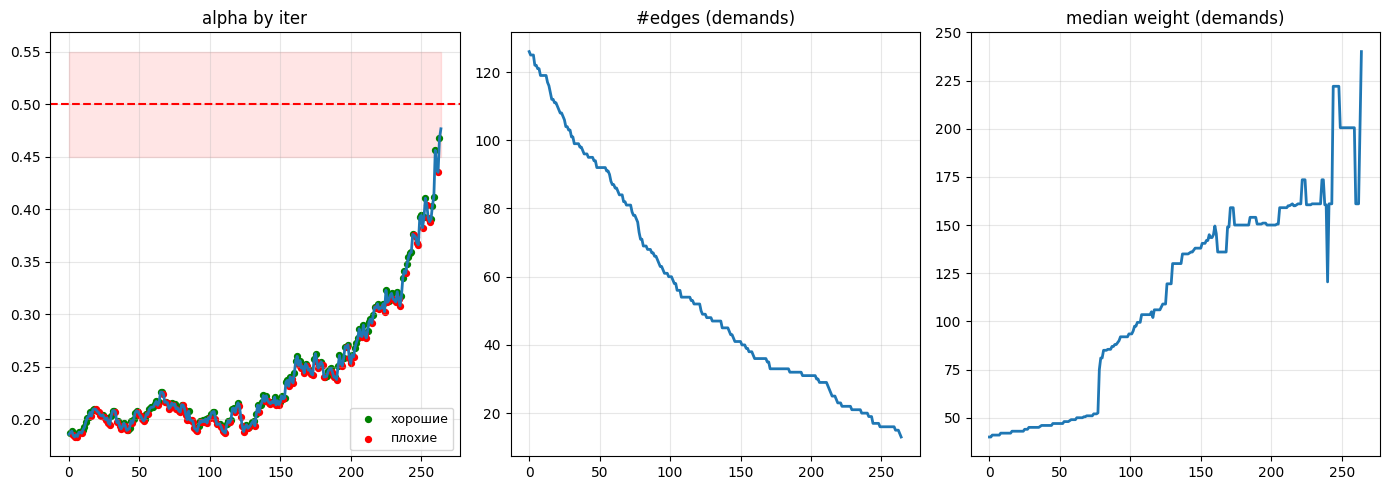

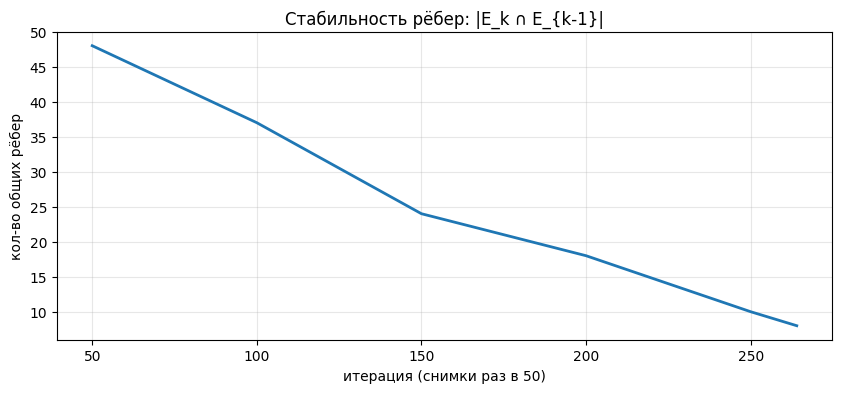

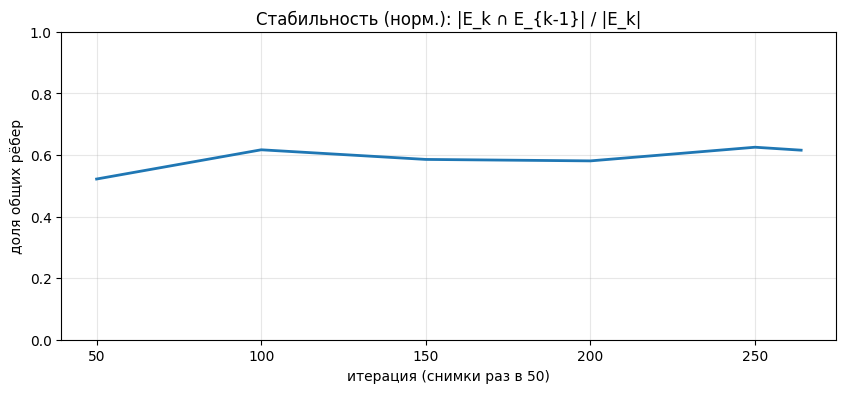

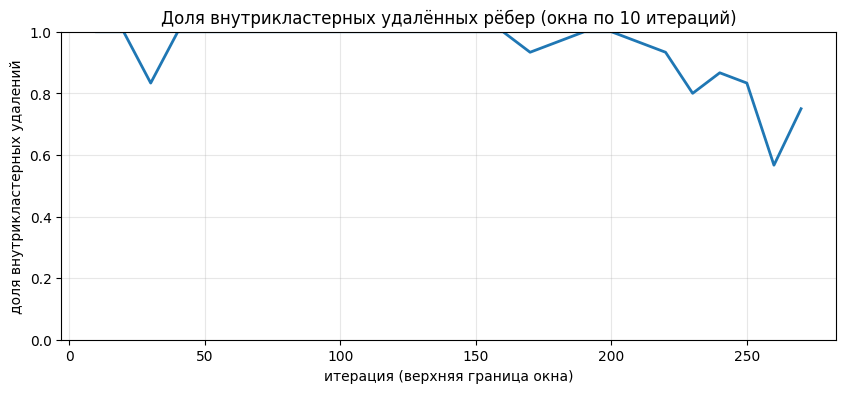

 метрика  initial  final
   edges      126     13
median_w       40    240
  mean_w       40    227
   sum_w     5038   2957


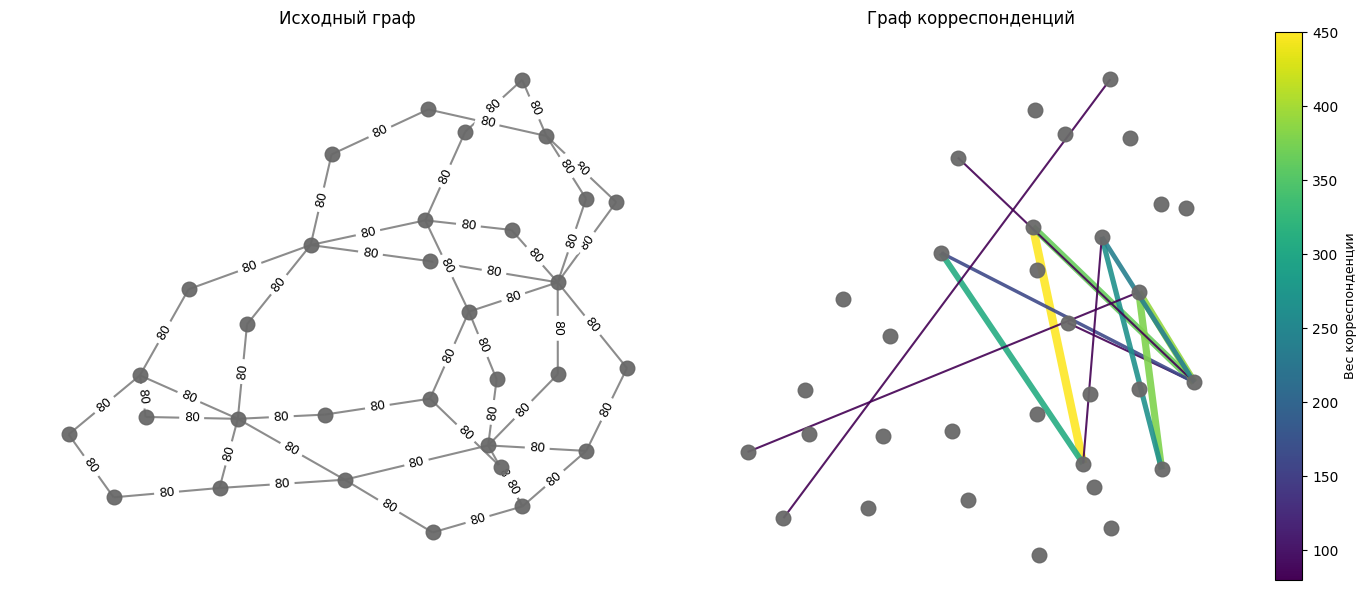

=================================== Конец анализа работы алгоритма для cola_t2 ===================================


In [17]:
import numpy as np
from graphmcf import GraphMCF
from graphmcf.demands import MCFGeneratorMultiEdges
from graphmcf.analysis import analyze_simple

for name, graph in Graphs_for_test.items():
  graph_for_mcf = GraphMCF(graph['adj_matrix'])
  gen = MCFGeneratorMultiEdges(epsilon=0.025,
                     p_ER = 0.25, distribution="normal", median_weight_for_initial=40, var_for_initial=20,
                     demands_median_denominator=2, demands_var_denominator=4,
                     num_edges=None, p_for_delete_edge=1.0, p_for_upsert_edge=1.0,)
  res = gen.generate(graph=graph_for_mcf, alpha_target=0.5)
  print(f"====================================   Анализ работы алгоритма для {name}  ====================================")
  analyze_simple(graph_for_mcf, alpha_target=0.5, epsilon=0.05,
               start_time=res.start_time, end_time=res.end_time,
               alpha_history=res.alpha_history,
               edge_counts_history=res.edge_counts_history,
               median_weights_history=res.median_weights_history,
               edge_mask_history=res.edge_mask_history,
               edge_mask_snapshot_iters=res.edge_mask_snapshot_iters,
               removal_events=res.removal_events,
               algo_params=res.algo_params)
  graph_for_mcf.visualise_with_demands()
  print(f"=================================== Конец анализа работы алгоритма для {name} ===================================")